In [97]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


In [98]:
# load all files into one dataframe, with exact number of file as separate sample
from pathlib import Path

activities = ["idle", "running", "stairs", "walking"]
data_collections = []

for index, activity in enumerate(activities, start=1):
    activity_path = Path("data") / activity
    csv_files = list(activity_path.glob("*.csv"))
    for sample_no, file in enumerate(csv_files, start=1):
        sample = pd.read_csv(file)
        sample["sample_no"] = sample_no
        sample["activity"] = activity
        data_collections.append(sample)

df = pd.concat(data_collections, ignore_index=True)
df

,accelerometer_X,accelerometer_Y,accelerometer_Z,sample_no,activity
0,1.000776,4.616021,8.576031,1,idle
1,0.718261,4.209007,8.446744,1,idle
2,-0.909797,-0.282516,9.203311,1,idle
3,5.099650,0.148441,8.418014,1,idle
4,1.762132,-0.162806,9.251195,1,idle
...,...,...,...,...,...
193855,5.109226,-15.452178,-1.470040,1850,walking
193856,6.373365,-11.741165,-8.226476,1850,walking
193857,3.289633,-9.993398,-0.383072,1850,walking
193858,-2.978387,-3.050213,1.273715,1850,walking


In [99]:
# accelerometer data normalization
from sklearn.preprocessing import StandardScaler

features = ["accelerometer_X", "accelerometer_Y", "accelerometer_Z"]

scaler = StandardScaler(copy=False)
df[features] = scaler.fit_transform(df[features])
df

,accelerometer_X,accelerometer_Y,accelerometer_Z,sample_no,activity
0,-0.109791,0.241917,0.941538,1,idle
1,-0.143404,0.209288,0.923560,1,idle
2,-0.337109,-0.150782,1.028762,1,idle
3,0.377889,-0.116234,0.919565,1,idle
4,-0.019205,-0.141185,1.035420,1,idle
...,...,...,...,...,...
193855,0.379029,-1.366884,-0.455385,1850,walking
193856,0.529435,-1.069384,-1.394879,1850,walking
193857,0.162535,-0.929271,-0.304241,1850,walking
193858,-0.583227,-0.372659,-0.073862,1850,walking


In [100]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df["activity"],
    test_size=0.5,
    stratify=df["activity"],
    random_state=41
)



In [101]:
from sklearn.svm import SVC

model_svm = SVC()
model_svm.fit(X_train, y_train)

SVC()

In [102]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [103]:
score_svm = model_svm.score(X_test, y_test)
score_rf = model_rf.score(X_test, y_test)

print(f"Точність моделі SVM: {score_svm:.3f}")
print(f"Точність моделі випадкового лісу: {score_rf:.3f}")

Точність моделі SVM: 0.892
Точність моделі випадкового лісу: 1.000


In [104]:
from sklearn.metrics import confusion_matrix

y_predicted_svm = model_svm.predict(X_test)
y_predicted_rf = model_rf.predict(X_test)

conf_matrix_svm = confusion_matrix(y_test, y_predicted_svm)
conf_matrix_rf = confusion_matrix(y_test, y_predicted_rf)

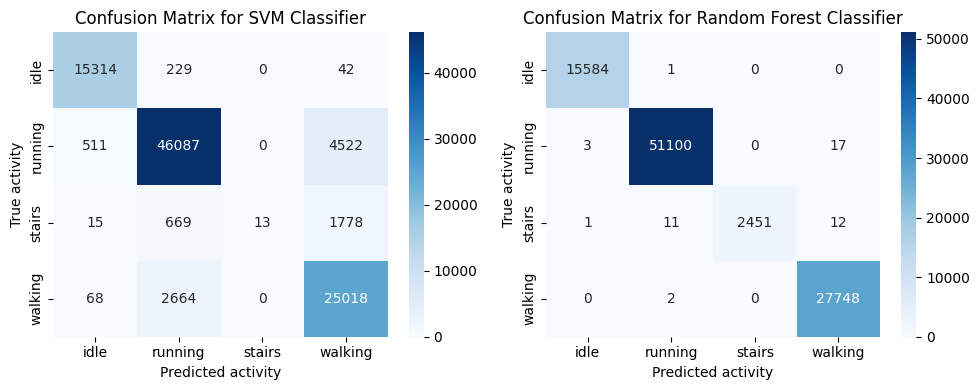

In [105]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

classifiers = ["SVM", "Random Forest"]
confusion_matrices = [conf_matrix_svm, conf_matrix_rf]

for i, classifier in enumerate(classifiers):
    sns.heatmap(
        confusion_matrices[i],
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=activities,
        yticklabels=activities,
        ax=axes[i],
    )
    axes[i].set_title(f"Confusion Matrix for {classifier} Classifier")
    axes[i].set_xlabel("Predicted activity")
    axes[i].set_ylabel("True activity")

plt.tight_layout()

plt.show()

We extract 17 time domain features from each window for each axis x, y and z. 
individual features for each axis involves statistical attributes such as mean, variance, standard deviation and
envelope metrics, i.e. median, range maximum and minimum value, root mean square metric. Furthermore, we use
signal magnitude area, indexes of minimum and maximum value, power, energy, entropy, skewness, kurtosis,
interquartile range, and mean absolute deviation of signal. To see the cross-relational effects of different motion
axes, we also use cross correlation of binary combinations of x, y, and z.

Ми вилучаємо 17 часових характеристик з кожного вікна для кожної осі x, y та z. 
Індивідуальні характеристики для кожної осі включають статистичні атрибути, такі як середнє значення, дисперсія, середньоквадратичне відхилення та
метрики огинаючої, тобто медіану, максимальне та мінімальне значення діапазону, середньоквадратичну метрику. Крім того, ми використовуємо
площа амплітуди сигналу, індекси мінімального та максимального значення, потужність, енергія, ентропія, асиметрія, ексцес
міжквартильний розмах та середнє абсолютне відхилення сигналу. Для того, щоб побачити перехресний вплив різних осей руху, ми також використовуємо перехресну кореляцію, ми також використовуємо перехресну кореляцію бінарних комбінацій x, y та z.


In [106]:
# time domain features calculation functions

from scipy.stats import entropy, skew, kurtosis


def power(signal):
    return np.sum(signal**2) / len(signal)


def energy(signal):
    return np.sum(signal**2)


def entropy_(signal):
    hist, bins = np.histogram(signal, bins="auto")
    probabilities = hist / len(signal)

    probabilities = probabilities[probabilities > 0]
    entropy_value = entropy(probabilities, base=2)

    return entropy_value


# interquartile range (1 axis)
def iqr(signal):
    q75, q25 = np.percentile(signal, [75, 25])
    iqr = q75 - q25
    return iqr


# mean absolute deviation (1 axis)
def mad(signal):
    mean = np.mean(signal)
    mad = np.sum(np.abs(signal - mean)) / len(signal)
    return mad


# root mean square error (1 axis)
def rmse(signal):
    mean = np.mean(signal)
    squared_errors = [(x - mean) ** 2 for x in signal]
    rmse = np.sqrt(np.mean(squared_errors))
    return rmse


def argmin(signal):
    return np.argmin(signal)


def argmax(signal):
    return np.argmax(signal)


def kurtosis_(signal):
    return kurtosis(signal)


# cross correlation X-Y (2 axis)
def cross_corr_XY(series):
    return np.correlate(
        series["accelerometer_X"], series["accelerometer_Y"], mode="same"
    ).mean()


# cross correlation Y-Z (2 axis)
def cross_corr_YZ(series):
    return np.correlate(
        series["accelerometer_Y"], series["accelerometer_Z"], mode="same"
    ).mean()


# cross correlation X-Z (2 axis)
def cross_corr_XZ(series):
    return np.correlate(
        series["accelerometer_X"], series["accelerometer_Z"], mode="same"
    ).mean()


# signal magnitude area (3 axis)
def sma(series):
    sma = (
        np.abs(series["accelerometer_X"])
        + np.abs(series["accelerometer_Y"])
        + np.abs(series["accelerometer_Z"])
    ).mean()
    return sma

In [107]:
one_axis_funcs = [
    "mean",
    "var",
    "std",
    "median",
    "min",
    "max",
    rmse,
    argmin,
    argmax,
    power,
    energy,
    entropy_,
    "skew",
    kurtosis_,
    iqr,
    mad,
]
df_tdf = (
    df.groupby(["activity", "sample_no"])
    .agg(
        {
            "accelerometer_X": one_axis_funcs,
            "accelerometer_Y": one_axis_funcs,
            "accelerometer_Z": one_axis_funcs,
        }
    )
    .reset_index()
)
axis = ["x", "y", "z"]

cols = ["activity", "sample_no"]

for ax in axis:
    for func in one_axis_funcs:
        if type(func) != str:
            col_name = f"{ax}_{func.__name__}"
        else:
            col_name = f"{ax}_{func}"
        cols.append(col_name)

df_tdf.columns = cols


df_tdf["cross_corr_XY"] = (
    df.groupby(["activity", "sample_no"]).apply(cross_corr_XY).values
)

df_tdf["cross_corr_YZ"] = (
    df.groupby(["activity", "sample_no"]).apply(cross_corr_YZ).values
)

df_tdf["cross_corr_XZ"] = (
    df.groupby(["activity", "sample_no"]).apply(cross_corr_XZ).values
)


df_tdf["SMA"] = (
    df.groupby(["activity", "sample_no"]).apply(sma).values
)

df_tdf

,activity,sample_no,x_mean,x_var,x_std,x_median,x_min,x_max,x_rmse,x_argmin,...,z_energy,z_entropy_,z_skew,z_kurtosis_,z_iqr,z_mad,cross_corr_XY,cross_corr_YZ,cross_corr_XZ,SMA
0,idle,1,-0.207630,0.015204,0.123305,-0.241111,-0.337109,0.377889,0.121233,2,...,35.390996,2.277957,-2.365312,3.481228,0.004827,0.038315,0.600096,-2.984194,-5.242708,1.462329
1,idle,2,-0.240598,0.000224,0.014973,-0.242535,-0.267033,-0.180436,0.014722,3,...,36.812339,2.485918,-2.409922,7.285421,0.002663,0.002317,0.751016,-3.455767,-6.001570,1.486980
2,idle,3,-0.240750,0.000003,0.001861,-0.240826,-0.243675,-0.236268,0.001830,7,...,36.787022,2.526027,-0.097477,-0.752640,0.002663,0.001623,0.598569,-2.754553,-5.997941,1.458527
3,idle,4,-0.181157,0.000040,0.006293,-0.182145,-0.196958,-0.162205,0.006187,29,...,36.639769,2.333057,0.565957,-0.150002,0.003163,0.001931,0.531253,-3.243241,-4.500970,1.416792
4,idle,5,-0.181157,0.000040,0.006328,-0.181006,-0.196958,-0.162205,0.006222,27,...,36.650091,2.357544,0.453139,-0.583786,0.003829,0.002086,0.531260,-3.240848,-4.504866,1.416755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6457,walking,1846,-0.181670,0.170856,0.413347,-0.182430,-0.941581,0.626857,0.406400,1,...,44.453490,2.757882,1.221757,6.038754,0.415648,0.660552,4.350148,6.196336,1.487460,2.044943
6458,walking,1847,-0.179125,0.176790,0.420463,-0.182430,-1.104521,0.626857,0.413396,29,...,44.290573,2.811537,1.178148,5.941852,0.415648,0.661086,4.024627,5.485204,1.093841,2.039001
6459,walking,1848,-0.091825,0.220649,0.469733,-0.050255,-1.104521,1.093457,0.461838,27,...,35.876965,2.755913,1.996085,8.300254,0.415648,0.579176,2.382714,4.101512,0.442672,1.997899
6460,walking,1849,-0.044311,0.228418,0.477931,-0.004108,-1.104521,1.093457,0.469898,25,...,36.813973,2.850050,1.959435,8.013279,0.415648,0.592431,1.475805,4.074648,0.135170,2.036275


In [108]:
X_train, X_test, y_train, y_test = train_test_split(
    df_tdf.iloc[:, 3:],
    df_tdf["activity"],
    test_size=0.3,
    stratify=df_tdf["activity"],
)

In [109]:
model_svm = SVC()
model_svm.fit(X_train, y_train)

SVC()

In [110]:
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [111]:
score_svm = model_svm.score(X_test, y_test)
score_rf = model_rf.score(X_test, y_test)

print(f"Точність моделі SVM: {score_svm:.3f}")
print(f"Точність моделі випадкового лісу: {score_rf:.3f}")

Точність моделі SVM: 0.986
Точність моделі випадкового лісу: 0.999


In [112]:
y_predicted_svm = model_svm.predict(X_test)
y_predicted_rf = model_rf.predict(X_test)

In [113]:
conf_matrix_svm = confusion_matrix(y_test, y_predicted_svm)
conf_matrix_rf = confusion_matrix(y_test, y_predicted_rf)

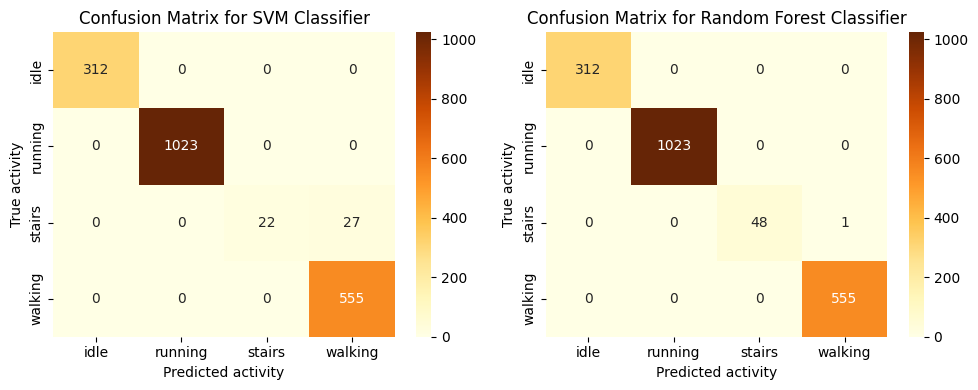

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

classifiers = ["SVM", "Random Forest"]
confusion_matrices = [conf_matrix_svm, conf_matrix_rf]

for i, classifier in enumerate(classifiers):
    sns.heatmap(
        confusion_matrices[i],
        annot=True,
        fmt="d",
        cmap="YlOrBr",
        xticklabels=activities,
        yticklabels=activities,
        ax=axes[i],
    )
    axes[i].set_title(f"Confusion Matrix for {classifier} Classifier")
    axes[i].set_xlabel("Predicted activity")
    axes[i].set_ylabel("True activity")

plt.tight_layout()

plt.show()

1 Класифікатор SVM працює повільніше і робить більше помилок (особливо в першому варіанті, коли використовуються тільки показники акселерометра). 


2 Класифікатор "Випадковий ліс" набагато краще підходить для цієї задачі, і швидше праціює

З використанням Time Domain Features значно збфльшується точність класифікації, майже ідеальна, за виключенням 27 випадків коли SVM помилково сплутав ходу по сходах з просто прогулкою, а випадкоаий ліс всього в 1 (!) випадку. Також робота обох моделй значно пришвидшилася бо ми знизили в 30 разів кількість рядків у  датасеті що обробляється